In [8]:
%pip install scikit-learn

                                              0.0/10.6 MB ? eta -:--:--
                                             0.0/10.6 MB 640.0 kB/s eta 0:00:17
                                             0.0/10.6 MB 640.0 kB/s eta 0:00:17
                                             0.0/10.6 MB 279.3 kB/s eta 0:00:38
                                             0.1/10.6 MB 381.3 kB/s eta 0:00:28
                                             0.1/10.6 MB 374.1 kB/s eta 0:00:29
                                             0.1/10.6 MB 423.5 kB/s eta 0:00:25
                                             0.2/10.6 MB 490.7 kB/s eta 0:00:22
                                             0.2/10.6 MB 512.0 kB/s eta 0:00:21
                                             0.2/10.6 MB 497.6 kB/s eta 0:00:21
                                             0.2/10.6 MB 537.7 kB/s eta 0:00:20
     -                                       0.3/10.6 MB 548.9 kB/s eta 0:00:19
     -                                       0.3


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------             7.5/10.6 MB 132.4 kB/s eta 0:00:24
     ---------------------------             7.5/10.6 MB 132.4 kB/s eta 0:00:24
     ---------------------------             7.5/10.6 MB 132.4 kB/s eta 0:00:24
     ---------------------------             7.5/10.6 MB 132.4 kB/s eta 0:00:24
     ---------------------------             7.5/10.6 MB 132.4 kB/s eta 0:00:24
     ---------------------------             7.5/10.6 MB 132.6 kB/s eta 0:00:24
     ---------------------------             7.5/10.6 MB 133.5 kB/s eta 0:00:24
     ---------------------------             7.5/10.6 MB 133.5 kB/s eta 0:00:24
     ---------------------------             7.5/10.6 MB 133.5 kB/s eta 0:00:24
     ---------------------------             7.5/10.6 MB 133.5 kB/s eta 0:00:24
     ---------------------------             7.5/10.6 MB 133.5 kB/s eta 0:00:24
     ---------------------------             7.5/10.6 MB 133.5 kB/s eta 0:00:24
     ---------------------------       

In [20]:
import pandas as pd
import re,os,sys
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [16]:
rating_df=pd.read_csv("../data/rating.csv")
domain_locations_df = pd.read_csv("../data/domains_location.csv")
traffic_data_df = pd.read_csv("../data/traffic.csv")

# Drop duplicates
rating_df.drop_duplicates(inplace=True)
domain_locations_df.drop_duplicates(inplace=True)
traffic_data_df.drop_duplicates(inplace=True)

# Drop unnecessary columns
if 'source_id' in rating_df.columns:
    rating_df.drop(columns=['source_id'], inplace=True)

if 'url_to_image' in rating_df.columns:
    rating_df.drop(columns=['url_to_image'], inplace=True)

# Drop rows with missing values
rating_df = rating_df.dropna(axis=0)
domain_locations_df = domain_locations_df.dropna(axis=0)

# rating_df['domain'] = rating_df['url'].apply(get_domain)

merge_df=pd.merge(rating_df, domain_locations_df ,left_on='source_name', right_on ='SourceCommonName' ,how ='left')
merge_df=pd.merge(merge_df, traffic_data_df , left_on ='source_name' ,right_on='Domain' ,how ='left')

Number of events: 10
News sites reporting events earliest:
 source_name
Android Central                 2023-10-01 20:00:46.000000
Al Jazeera English              2023-10-01 20:22:17.000000
Deadline                        2023-10-01 23:35:34.000000
BBC News                        2023-10-02 00:04:05.000000
Business Insider                2023-10-02 00:10:25.000000
RT                              2023-10-02 01:32:33.000000
Forbes                          2023-10-02 02:03:15.000000
The Indian Express              2023-10-02 02:04:23.000000
International Business Times    2023-10-02 02:45:30.000000
Time                            2023-10-02 05:00:00.000000
GlobeNewswire                   2023-10-02 05:30:00.000000
The Times of India              2023-10-02 06:42:03.000000
Phys.Org                        2023-10-02 07:30:39.000000
Globalsecurity.org              2023-10-02 08:07:51.000000
Marketscreener.com              2023-10-02 08:16:05.000000
NPR                             2023-10-02 

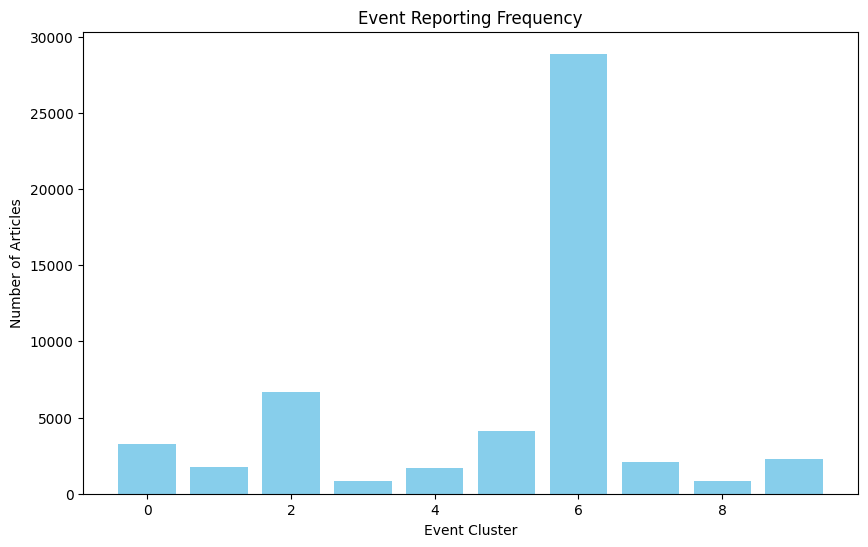

In [19]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    tokens = word_tokenize(text)
    # Remove stop words and apply stemming
    filtered_tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    # Join the filtered tokens back into text
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text

merge_df['preprocessed_content'] = merge_df['content'].apply(preprocess_text)

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(merge_df['preprocessed_content'])

#  Clustering
num_clusters = 10  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)


merge_df['cluster'] = kmeans.labels_

# Count the number of events covered in the data
num_events = merge_df['cluster'].nunique()
print("Number of events:", num_events)

# Determine which news sites report events the earliest
earliest_reporting = merge_df.groupby('source_name')['published_at'].min()
earliest_reporting = earliest_reporting.sort_values()
print("News sites reporting events earliest:\n", earliest_reporting)

event_counts = merge_df['cluster'].value_counts()
print("Event reporting frequency:\n", event_counts)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(event_counts.index, event_counts.values, color='skyblue')
plt.xlabel('Event Cluster')
plt.ylabel('Number of Articles')
plt.title('Event Reporting Frequency')
plt.show()
